# Comparison between classical and quantum running times for MNIST experiment

### Setup

In [1]:
import os
os.chdir("../../quantum_eigenfaces/package/")
import IPython

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import glob
import re
import csv 

from tqdm import tqdm
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from quantum_eigenfaces.epsilon_tuning import epsilon_tuning 
from quantum_eigenfaces.utils.utils import DataSplit, TrainingConfig, TuningConfig



### Load MNIST Dataset

In [4]:
import joblib
memory_mnist = joblib.Memory('./tmp_mnist')
fetch_openml_cached_mnist = memory_mnist.cache(fetch_openml)

X, y = fetch_openml_cached_mnist('mnist_784', version=1, return_X_y=True)  

n_labels = len(set(y))

train_val_test = [0.70,0.15,0.15]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_val_test[2], random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=train_val_test[1]/(1-train_val_test[2]), random_state=1)

tot = len(X_train) + len(X_val) + len(X_test) 
print(f"Datapoints number: {tot}")
print(f"Classes number: {n_labels}")
print(f"Training set: {len(X_train)/tot}")
print(f"Validation set: {len(X_val)/tot}")
print(f"Test set: {len(X_test)/tot}")


X_train = X_train.to_numpy()
X_valid = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy().astype(int)
y_valid = y_val.to_numpy().astype(int)
y_test = y_test.to_numpy().astype(int)



Datapoints number: 70000
Classes number: 10
Training set: 0.7
Validation set: 0.15
Test set: 0.15


### Load Outliers: Fashion MNIST

In [5]:
import joblib
memory = joblib.Memory('./tmp')
fetch_openml_cached = memory.cache(fetch_openml)

X, y = fetch_openml_cached(data_id=40996, return_X_y=True) # Fashion MNIST

n_labels = len(set(y))

train_val_test = [0.70,0.05,0.05]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=train_val_test[2], random_state=1)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train2, y_train2, test_size=train_val_test[1]/(1-train_val_test[2]), random_state=1)


tot = len(X_train2) + len(X_val2) + len(X_test2) 
print(f"Datapoints number: {tot}")
print(f"Classes number: {n_labels}")
print(f"Training set: {len(X_train2)/tot}")
print(f"Validation set: {len(X_val2)/tot}")
print(f"Test set: {len(X_test2)/tot}")


Datapoints number: 70000
Classes number: 10
Training set: 0.8999857142857143
Validation set: 0.05001428571428571
Test set: 0.05


### Combine datasets

In [6]:

X_valid_wa = np.concatenate([X_valid, X_val2.to_numpy()])
y_valid_wa = np.concatenate([[int(y) for y in y_valid], [-1 for _ in range(len(X_val2))]])
X_test_wa = np.concatenate([X_test, X_test2.to_numpy()])
y_test_wa = np.concatenate([[int(y) for y in y_test], [-1 for _ in range(len(X_test2))]])



### Normalization

In [7]:
X_train_n = X_train / 255
X_valid_n = X_valid / 255
X_valid_wa_n = X_valid_wa / 255
X_test_n = X_test / 255
X_test_wa_n = X_test_wa / 255

In [8]:
print(f"X_train_n:    {X_train.shape}")
print(f"y_train:      {y_train.shape}")
print("------------------------")
print(f"X_valid_n:    {X_valid.shape}")
print(f"y_valid:      {y_valid.shape}")
print(f"X_valid_wa_n: {X_valid_wa.shape}")
print(f"y_valid_wa:   {y_valid_wa.shape}")
print("------------------------")
print(f"X_test_n:     {X_test.shape}")
print(f"y_test:       {y_test.shape}")
print(f"X_test_wa_n:  {X_test_wa.shape}")
print(f"y_test_wa:    {y_test_wa.shape}")

X_train_n:    (49000, 784)
y_train:      (49000,)
------------------------
X_valid_n:    (10500, 784)
y_valid:      (10500,)
X_valid_wa_n: (14001, 784)
y_valid_wa:   (14001,)
------------------------
X_test_n:     (10500, 784)
y_test:       (10500,)
X_test_wa_n:  (14000, 784)
y_test_wa:    (14000,)


### Formalize dataset splits and fitting configurations

In [9]:

datasplit_without_outliers = DataSplit(X_train=X_train_n, 
                                        y_train=y_train, 
                                        X_valid=X_valid_n, 
                                        y_valid=y_valid, 
                                        X_test=X_test_n, 
                                        y_test=y_test)

datasplit_with_outliers = DataSplit(X_train=X_train_n, 
                                    y_train=y_train, 
                                    X_valid=X_valid_wa_n, 
                                    y_valid=y_valid_wa, 
                                    X_test=X_test_wa_n, 
                                    y_test=y_test_wa)

training_config = TrainingConfig(n_components=60)
tuning_config = TuningConfig(tot_num_of_deltas=1600)



## Fit model

In [17]:
from quantum_eigenfaces.quantum_model import QuantumModel
qm = QuantumModel(X_train=X_train_n,
                  y_train=y_train,
                  X_valid=X_valid_n,
                  y_valid=y_valid,
                  X_test=X_test_n,
                  y_test=y_test,
                  reshaper=(28,28))

qm.fit(n_components=60, delta1=22.339989)


********* TRAINING **************
Normalization Threshold is: 0.748321
********* TUNING **************
delta1 has been chosen by the user. No delta1 tuning is performed.


In [18]:
epsilons = range(0, 90, 5)
qruntimes = []
cruntimes = []
stddev_qrts = []

for epsilon in epsilons:
    print("********")
    print("Epsilon: ", epsilon)
    qrt, crt = qm.runtime(epsilon=epsilon, num_components=60, verbose=False)
    stddev_qrt = np.std(qrt)
    stddev_qrts.append(stddev_qrt)
    qrt_ = np.mean(qrt)
    qruntimes.append(qrt_)
    cruntimes.append(crt)
    


********
Epsilon:  0
********
Epsilon:  5
sqrt p: 221.35943621178654
mu: 7.246272342260319
max_c_train_norm: 11.594908361891498
avg U_bar_norms: 7.179237349285472
epsilon: 5
********
Epsilon:  10
sqrt p: 221.35943621178654
mu: 7.246272342260319
max_c_train_norm: 11.594908361891498
avg U_bar_norms: 7.179237349285472
epsilon: 10
********
Epsilon:  15
sqrt p: 221.35943621178654
mu: 7.246272342260319
max_c_train_norm: 11.594908361891498
avg U_bar_norms: 7.179237349285472
epsilon: 15
********
Epsilon:  20
sqrt p: 221.35943621178654
mu: 7.246272342260319
max_c_train_norm: 11.594908361891498
avg U_bar_norms: 7.179237349285472
epsilon: 20
********
Epsilon:  25
sqrt p: 221.35943621178654
mu: 7.246272342260319
max_c_train_norm: 11.594908361891498
avg U_bar_norms: 7.179237349285472
epsilon: 25
********
Epsilon:  30
sqrt p: 221.35943621178654
mu: 7.246272342260319
max_c_train_norm: 11.594908361891498
avg U_bar_norms: 7.179237349285472
epsilon: 30
********
Epsilon:  35
sqrt p: 221.35943621178654
mu

In [19]:
rts = pd.DataFrame({"epsilon": epsilons, 
                    "classical runtime": cruntimes, 
                    "average runtime": qruntimes, 
                    "stddev runtime": stddev_qrts})


In [20]:
rts.loc[0, "average runtime"] = np.nan
rts

,epsilon,classical runtime,average runtime,stddev runtime
0,0,2987040,NaN,0.000000
1,5,2987040,26704.737929,3637.380417
2,10,2987040,13352.368964,1818.690208
3,15,2987040,8901.579310,1212.460139
4,20,2987040,6676.184482,909.345104
5,25,2987040,5340.947586,727.476083
6,30,2987040,4450.789655,606.230069
7,35,2987040,3814.962561,519.625774
8,40,2987040,3338.092241,454.672552
9,45,2987040,2967.193103,404.153380


### find highest acceptable epsilon
The highest $\epsilon$ that preserves at least $97.5\%$ of the accuracy with respect to the $\epsilon$-free scenario

In [21]:
np.random.seed(0)
epsilons_domain = np.arange(0, 25, 5) 
summary = epsilon_tuning(datasplit=datasplit_with_outliers, 
                         training_config=training_config, 
                         tuning_config=tuning_config,
                         reshaper=(28,28),
                         epsilons=epsilons_domain,
                         use_norm_threshold=True,
                         num_iterations=100,
                         delta1=22.34,
                         ds_name="MNIST",
                         compute_runtimes=False)


********* TRAINING **************
Normalization Threshold is: 0.746925
********* TUNING **************
delta1 has been chosen by the user. No delta1 tuning is performed.
_______
Epsilon: 0
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.9264285714285714
Avg Accuracy Train: 0.9406666666666667
Avg Recall: 0.8837142857142857
_______
Epsilon: 5
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.9262142857142858
Avg Accuracy Train: 0.9441904761904761
Avg Recall: 0.8722857142857143
_______
Epsilon: 10
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.9214285714285714
Avg Accuracy Train: 0.9475238095238095
Avg Recall: 0.8431428571428572
_______
Epsilon: 15
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.9141428571428571
Avg Accuracy Train: 0.9505714285714286
Avg Recall: 0.8048571428571428
_______
Epsilon: 20
Compute predictions...
********* TESTING **************


Avg Accuracy: 0.8955
Avg Accuracy Train: 0.9396190476190476
Avg Recall: 0.7631428571428571


In [22]:
summary

,epsilon,Accuracy,Accuracy Train,False Acceptance Rate,False Recognition Rate,Precision,Recall,F1-Score,Stddev Accuracy,Stddev Accuracy Train,Stddev False Acceptance Rate,Stddev False Recognition Rate,Stddev Precision,Stddev Recall,Stddev F1-Score
0,0,0.926429,0.940667,0.029071,0.031143,0.876452,0.883714,0.880068,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,0.926214,0.944190,0.031929,0.023857,0.901388,0.872286,0.886598,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,0.921429,0.947524,0.039214,0.014071,0.937421,0.843143,0.887786,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15,0.914143,0.950571,0.048786,0.006143,0.970375,0.804857,0.879900,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20,0.895500,0.939619,0.059214,0.002786,0.985609,0.763143,0.860225,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
from quantum_eigenfaces.utils.runtime import find_highest_acceptable_epsilon
highest_acceptable_epsilon = find_highest_acceptable_epsilon(summary)
print("highest acceptable epsilon: ", highest_acceptable_epsilon)

0.9264285714285714
0.9032678571428571
highest acceptable epsilon:  15


### Plot running times comparison

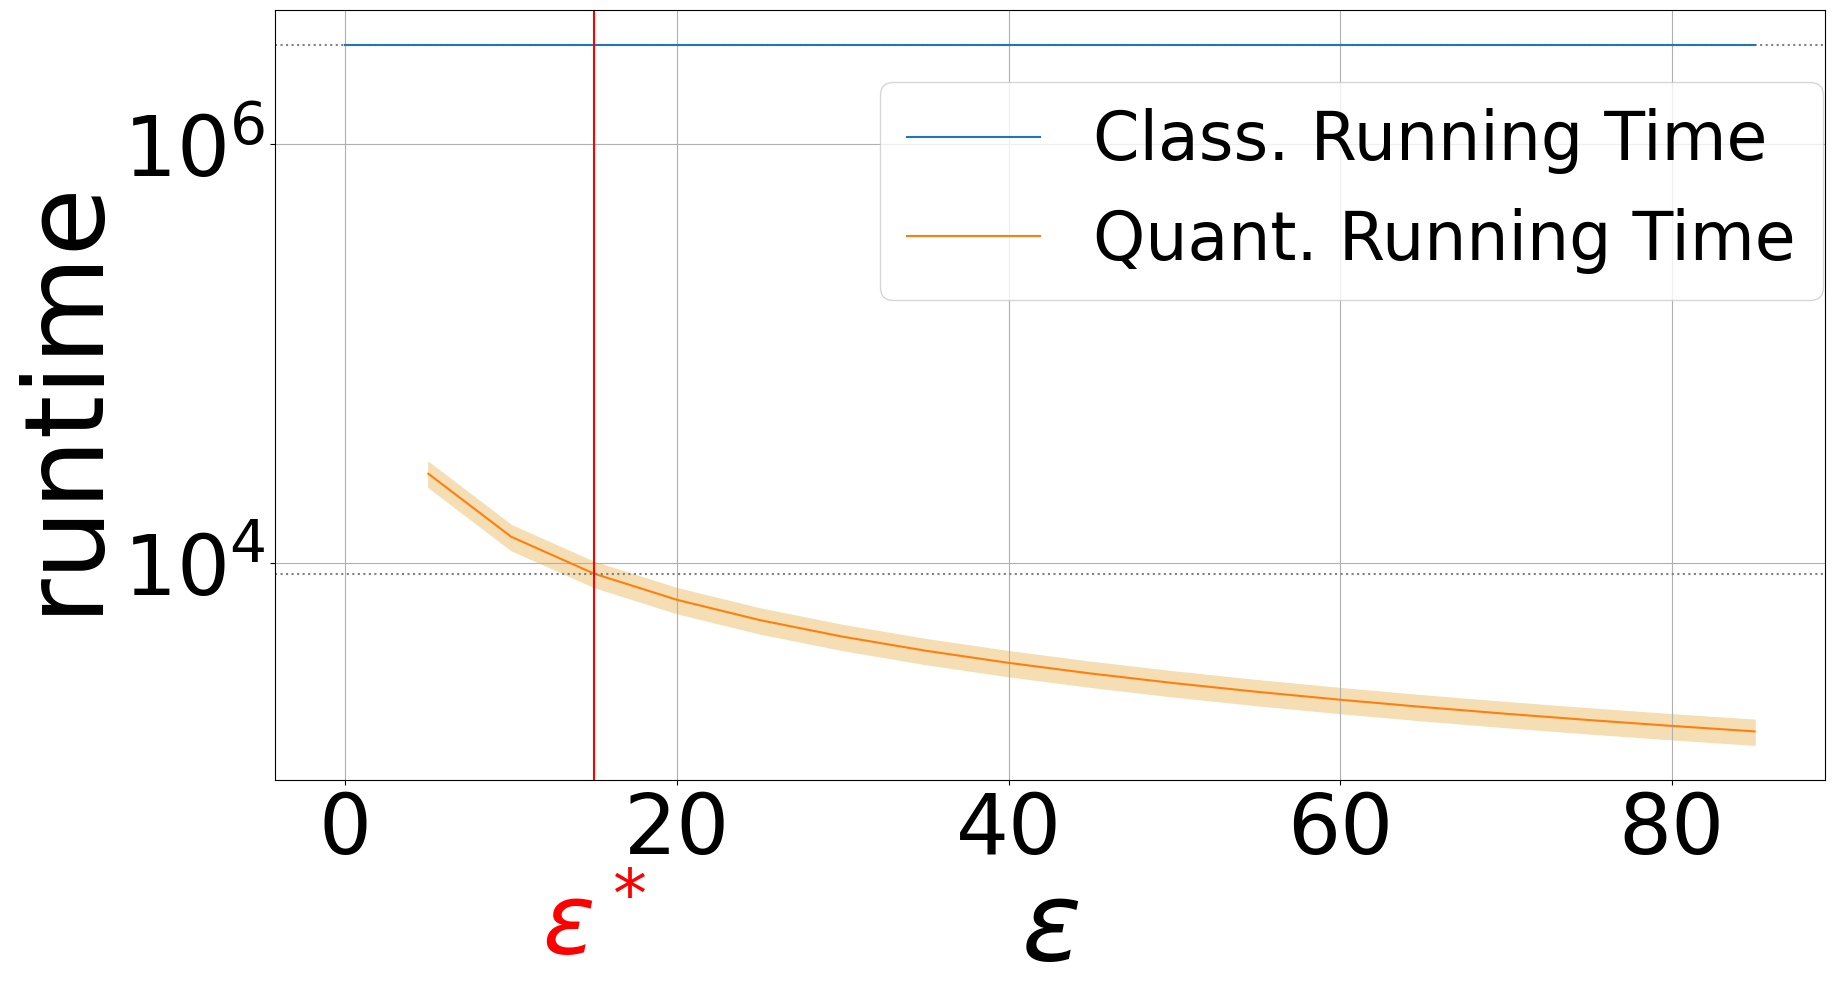

In [24]:
import matplotlib

def plot_quantum_vs_classical(rts, highest_acceptable_epsilon):
    plt.figure(figsize=(20, 10))

    fontsize = 60
    legend_fontsize = 48
    
    matplotlib.rcParams.update({'font.size': fontsize})

    x_padding = -16
    
    # Classical runtime
    crt = rts["classical runtime"].values[0]
    plt.axhline(crt, linestyle=":", c="grey")
    plt.plot(rts["epsilon"], rts["classical runtime"], label="Class. Running Time")
    
    # Quantum runtime
    avg_qrt = rts["average runtime"]
    stddev_qrt = rts["stddev runtime"]
    plt.plot(rts["epsilon"], avg_qrt, label="Quant. Running Time")
    plt.fill_between(epsilons, avg_qrt-stddev_qrts, avg_qrt+stddev_qrts, color="wheat")

    plt.xlabel("$\epsilon$", fontsize=fontsize + 20)
    plt.ylabel("runtime", fontsize=fontsize + 20)

    
    plt.yscale('log')

    plt.axvline(x=highest_acceptable_epsilon, c="red")

    plt.text(highest_acceptable_epsilon, 180, r'$\epsilon^*$', ha='center', va='center', c="red", fontsize=fontsize + 10)
    
    y = rts[rts["epsilon"] == highest_acceptable_epsilon]["average runtime"].values[0]
    plt.axhline(y, linestyle=":", c="grey")

    plt.grid(True)
    plt.legend(fontsize=legend_fontsize, loc="upper right", bbox_to_anchor=(1.02, 0.95))
    
    plt.xticks(rts["epsilon"].values[0:-1:4])
    plt.savefig("MNIST_quantum_runtime.pdf", bbox_inches='tight')
    
plot_quantum_vs_classical(rts=rts[0:], highest_acceptable_epsilon=highest_acceptable_epsilon)